In [3]:
# Install required packages
!pip install torch torchtext

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import re
from collections import Counter
import pickle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.7 MB/s eta 0:00:00


In [4]:
# Download Shakespeare text (or any text corpus)
!wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

# Read the text file
with open('shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read().lower()

# Show first 500 characters
print(text[:500])
print(f"\nTotal characters: {len(text)}")

--2025-10-25 13:48:21--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   1.06M  --.-KB/s    in 0.005s  

2025-10-25 13:48:21 (196 MB/s) - ‘shakespeare.txt’ saved [1115394/1115394]

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:
we know't, we know't.

first citizen:
let us kill him, and we'll have corn at our own price.
is't a verdict?

all:
no more talking on't; let it be done: away, away

**Cleaning and Preprocessing Text**

In [5]:
## Cleaning the text and special characters and keeping only letters and spaces
text = re.sub(r'[^-zA-Z\s]','',text)
# Splitting into sentences
sentences = [s.strip() for s in text.split('\n') if len(s.strip())>0]
print(f"Total sentences: {len(sentences)}")
print("Sample sentences")
for i in range(3):
  print(f"{i+1}.{sentences[i]}")

Total sentences: 1870
Sample sentences
1.z
2.z
3.z


**Building Vocabulary**

In [6]:
# Tokeninzing
all_words = []
for sentence in sentences:
   words = sentence.split()
   all_words.extend(words)

# Counting word frequencies


In [7]:
word_counts = Counter(all_words)
print(f"Total words: {len(all_words)}")
print(f"Unique words: {len(word_counts)}")

Total words: 1954
Unique words: 9


In [8]:
# Creating vocabolary - mapping each word to  aunique vector
vocab = ['<PAD>','<UNK>'] + [word for word , count in word_counts.most_common()]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx:word for word,idx in word_to_idx.items()}

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Show some word mappings
print("\nSample word to index mappings:")
for word in list(word_to_idx.keys())[:10]:
    print(f"{word} -> {word_to_idx[word]}")



Vocabulary size: 11

Sample word to index mappings:
<PAD> -> 0
<UNK> -> 1
- -> 2
z -> 3
-- -> 4
zz -> 5
--- -> 6
z- -> 7
-z -> 8
---- -> 9


**Creating training sequences**

In [9]:
input_sequences = []
target_words = []

for sentence in sentences:
  words = sentence.split()

  for i in range(1, len(words)):
    input_seq = words[:i]
    target = words[i]

    input_sequences.append(input_seq)
    target_words.append(target)
print(f"Total training examples: {len(input_sequences)}")
print("\nFirst 5 examples:")
for i in range(5):
    print(f"Input: {input_sequences[i]} -> Target: {target_words[i]}")


Total training examples: 84

First 5 examples:
Input: ['--'] -> Target: --
Input: ['--'] -> Target: --
Input: ['--'] -> Target: --
Input: ['--'] -> Target: --
Input: ['-'] -> Target: --


*Converting words to numbers and pad sequences*

In [11]:
# Converting words to indices (numbers)
def words_to_indices(word_list, word_to_idx):
    return [word_to_idx.get(word, word_to_idx['<UNK>']) for word in word_list]


In [16]:
# Converting all sequences to numbers
input_indices = [words_to_indices(seq, word_to_idx) for seq in input_sequences]
target_indices = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in target_words]

In [17]:
# Finding the longest sequence
max_len = max(len(seq) for seq in input_indices)
print(f"Maximum sequence length: {max_len}")

Maximum sequence length: 2


In [18]:
# padding sequences by adding zeros
def pad_sequence(sequence, max_len, pad_value=0):
  padded = [pad_value] * max_len
  padded[-len(sequence):] = sequence # Rightaligning the sequecne
  return padded
padded_inputs = [pad_sequence(seq, max_len) for seq in input_indices]

print(f"\nExample of padding:")
print(f"Original: {input_indices[10]}")
print(f"Padded: {padded_inputs[10]}")


Example of padding:
Original: [4]
Padded: [0, 4]


**Creating Pytorch Dataset**

In [22]:
# Custom Dataset class for PyTorch
class TextDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.LongTensor(inputs)  # Convert to PyTorch tensors
        self.targets = torch.LongTensor(targets)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create dataset
dataset = TextDataset(padded_inputs, target_indices)

# Create DataLoader - handles batching and shuffling
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")


Dataset size: 84
Number of batches: 2


In [23]:
# Define the neural network architecture
class NextWordLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(NextWordLSTM, self).__init__()

        # Embedding layer - converts word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer - processes sequences and remembers context
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=0.2)

        # Fully connected layer - produces predictions
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x shape: (batch_size, sequence_length)

        # Embed words: (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(x)

        # LSTM processing: output shape (batch_size, seq_len, hidden_dim)
        lstm_out, _ = self.lstm(embedded)

        # Take only the last time step's output
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_dim)

        # Predict next word: (batch_size, vocab_size)
        predictions = self.fc(last_output)

        return predictions

# Set hyperparameters
embedding_dim = 100  # Size of word embeddings
hidden_dim = 256     # Size of LSTM hidden state
num_layers = 2       # Number of LSTM layers stacked

# Create model
model = NextWordLSTM(vocab_size, embedding_dim, hidden_dim, num_layers)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Using device: {device}")
print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

Using device: cuda

Model architecture:
NextWordLSTM(
  (embedding): Embedding(11, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=11, bias=True)
)

Total parameters: 896,855


In [24]:
# Loss function - measures how wrong our predictions are
criterion = nn.CrossEntropyLoss()

# Optimizer - updates model weights to reduce loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
# Training loop
num_epochs = 20
train_losses = []

print("Starting training...\n")

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        # Move data to device (GPU/CPU)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass - get predictions
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass - calculate gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute new gradients

        # Update weights
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("\nTraining complete!")

Starting training...

Epoch [1/20], Loss: 2.3441
Epoch [2/20], Loss: 2.2411
Epoch [3/20], Loss: 2.0593
Epoch [4/20], Loss: 1.8503
Epoch [5/20], Loss: 1.6313
Epoch [6/20], Loss: 1.2045
Epoch [7/20], Loss: 1.0374
Epoch [8/20], Loss: 0.6423
Epoch [9/20], Loss: 0.6890
Epoch [10/20], Loss: 0.6069
Epoch [11/20], Loss: 0.6462
Epoch [12/20], Loss: 0.5057
Epoch [13/20], Loss: 0.7285
Epoch [14/20], Loss: 0.8469
Epoch [15/20], Loss: 0.5715
Epoch [16/20], Loss: 0.6718
Epoch [17/20], Loss: 0.4936
Epoch [18/20], Loss: 0.6528
Epoch [19/20], Loss: 0.5175
Epoch [20/20], Loss: 0.4498

Training complete!


In [26]:
def predict_next_words(model, seed_text, word_to_idx, idx_to_word, max_len, num_words=3):
    model.eval()  # Set to evaluation mode

    result = seed_text
    words = seed_text.split()

    with torch.no_grad():  # Don't calculate gradients during prediction
        for _ in range(num_words):
            # Convert words to indices
            indices = words_to_indices(words, word_to_idx)

            # Pad the sequence
            padded = pad_sequence(indices, max_len)

            # Convert to tensor
            input_tensor = torch.LongTensor([padded]).to(device)

            # Get prediction
            output = model(input_tensor)

            # Get the word with highest probability
            predicted_idx = torch.argmax(output, dim=1).item()

            # Convert index back to word
            predicted_word = idx_to_word[predicted_idx]

            # Add to result
            result += " " + predicted_word
            words.append(predicted_word)

    return result

# Test the model
test_sentences = [
    "to be or",
    "what is",
    "i love"
]

print("\n--- Model Predictions ---\n")
for sentence in test_sentences:
    prediction = predict_next_words(model, sentence, word_to_idx, idx_to_word, max_len, num_words=5)
    print(f"Input: '{sentence}'")
    print(f"Output: '{prediction}'")
    print()


--- Model Predictions ---

Input: 'to be or'
Output: 'to be or -- -- -- -- --'

Input: 'what is'
Output: 'what is -- -- -- -- --'

Input: 'i love'
Output: 'i love -- -- -- -- --'



In [27]:
# Save model weights
torch.save(model.state_dict(), 'next_word_lstm_pytorch.pth')

# Save vocabulary
with open('vocab.pkl', 'wb') as f:
    pickle.dump({
        'word_to_idx': word_to_idx,
        'idx_to_word': idx_to_word,
        'max_len': max_len
    }, f)

print("Model and vocabulary saved!")

Model and vocabulary saved!


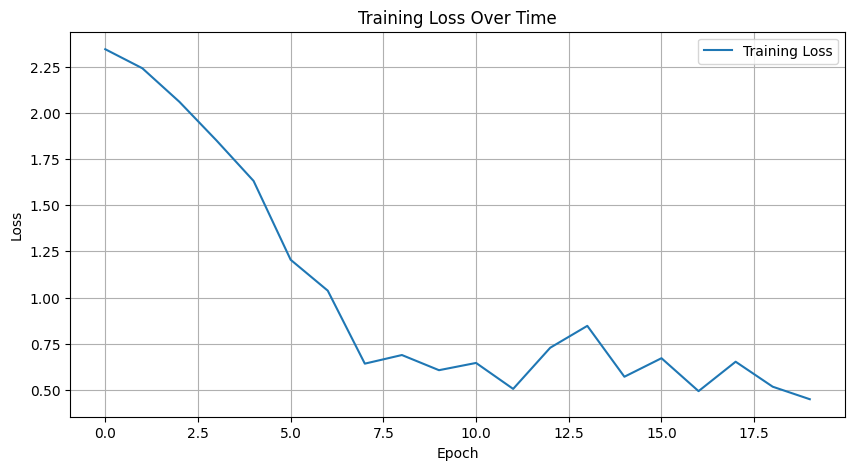

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
!pip install gradio

import gradio as gr

def autocomplete_interface(text, num_words):
    return predict_next_words(model, text, word_to_idx, idx_to_word, max_len, int(num_words))

interface = gr.Interface(
    fn=autocomplete_interface,
    inputs=[
        gr.Textbox(label="Enter seed text", placeholder="to be or not"),
        gr.Slider(1, 10, value=3, step=1, label="Number of words to predict")
    ],
    outputs=gr.Textbox(label="Predicted sentence"),
    title="🤖 Next Word Prediction with PyTorch LSTM",
    description="Enter some text and watch the AI complete your sentence!"
)

interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5e4fa025cc71f3e252.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
